## Monte Carlo Dropout Code

The code in this notebook is a step‐by‐step PyTorch tutorial demonstrating how to implement Monte Carlo (MC) dropout as an ensemble method.

### Setup and Imports

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

###  Define Model Architecture: a Neural Network with Dropout
We include dropout layers that will be active during both training and MC inference. During training, **dropout** is a **regularization technique**. During inference, dropout is an ensemble technique.

In [2]:
class MCDropoutNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(MCDropoutNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Dropout layer
        output = self.fc3(x)
        return output

### 3. Load the Data

In [3]:
# Generate synthetic data: y = sin(2*pi*x) with noise
np.random.seed(0)
x = np.linspace(0, 1, 100)[:, None]
y = np.sin(2 * np.pi * x) + 0.1 * np.random.randn(*x.shape)

# Convert to PyTorch tensors
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

### Train the Model
Here, we will train the model using mean squared error loss and the Adam optimizer.

In [4]:
# Model hyperparameters
input_dim = 1
hidden_dim = 64
output_dim = 1
dropout_rate = 0.2
num_epochs = 500
learning_rate = 0.01

# Initialize model, loss, and optimizer
model = MCDropoutNet(input_dim, hidden_dim, output_dim, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()  # Ensure dropout is active during training
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = model(x_tensor)
    loss = criterion(predictions, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
print("Training is complete")

Epoch [100/500], Loss: 0.0799
Epoch [200/500], Loss: 0.0405
Epoch [300/500], Loss: 0.0440
Epoch [400/500], Loss: 0.0289
Epoch [500/500], Loss: 0.0306
Training is complete


### Monte Carlo Dropout Inference



In [5]:
def mc_dropout_predict(model, x, n_samples=100):
    model.train()  # Activate dropout during inference
    predictions = []
    with torch.no_grad():
        for _ in range(n_samples):
            preds = model(x)
            predictions.append(preds.cpu().numpy())
    predictions = np.array(predictions)  # Shape: (n_samples, batch_size, output_dim)
    return predictions

# Generate predictions with MC dropout
n_samples = 100
mc_predictions = mc_dropout_predict(model, x_tensor, n_samples)

# Compute mean and standard deviation
pred_mean = mc_predictions.mean(axis=0).squeeze()   # shape: (batch_size,)
pred_std = mc_predictions.std(axis=0).squeeze()

### Visualize the Ensemble Predictions and Uncertainty

We plot the mean prediction along with the uncertainty bands (e.g., ±1 standard deviation).

Uncertainty Estimation: Here we use the mean and standard deviation of the predictions as an estimate of the prediction and its uncertainty, respectively.

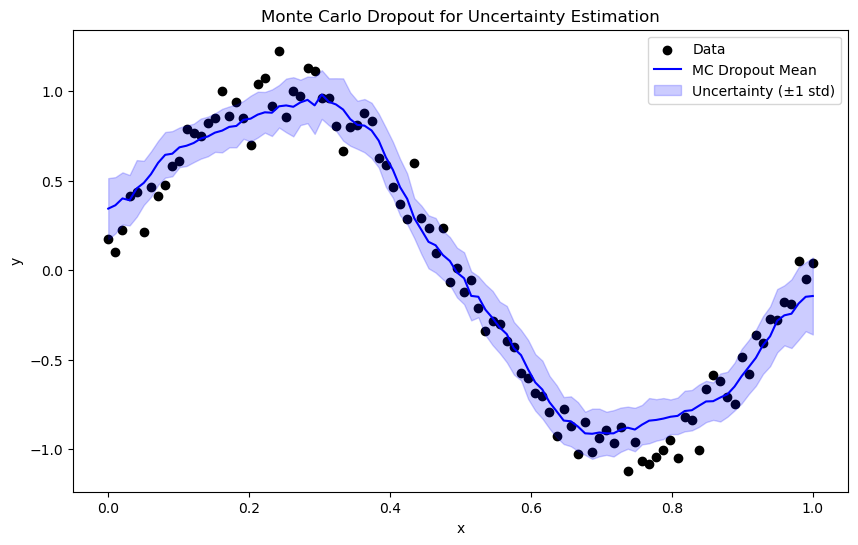

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, color='black', label='Data')
plt.plot(x, pred_mean, color='blue', label='MC Dropout Mean')
plt.fill_between(x.squeeze(), 
                 pred_mean - pred_std, 
                 pred_mean + pred_std, 
                 color='blue', alpha=0.2, label='Uncertainty (±1 std)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Monte Carlo Dropout for Uncertainty Estimation')
plt.show()
